In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
import sys
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')


In [2]:
#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.wppi_projected_correlation_functions as wz
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd
from AGNclustering.wppi_utils import wppi_d1d2,wppi_dd

Assumes BASS catalog, galaxy catalogs, and sensitivity maps are in folder `data_directory'

## Initialize the cosmology
see here for reference: http://docs.astropy.org/en/stable/cosmology/

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Read in AGN catalog
From Swift/BAT AGN Spectroscopic Survey: Local, hard X-ray selected

In [4]:
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

List the names of the columns in the catalog. For the clustering code, you need at least 'ra', 'dec', and 'z'

In [5]:
agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

Limit catalog to preferred luminosity & redshift range  
Here, we choose AGN with X-ray luminosities $>10^{42.5}$ erg/s, in the redshift range $0.01<z<0.1$:

In [6]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]

In [7]:
len(agn) #gives number of AGN in catalog (length of the array)

724

## Read in galaxy catalog

In [8]:
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)

In [9]:
gal.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'cdist')

In [10]:
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
len(gal)

38567

## Plot positions of AGN, galaxies on the sky

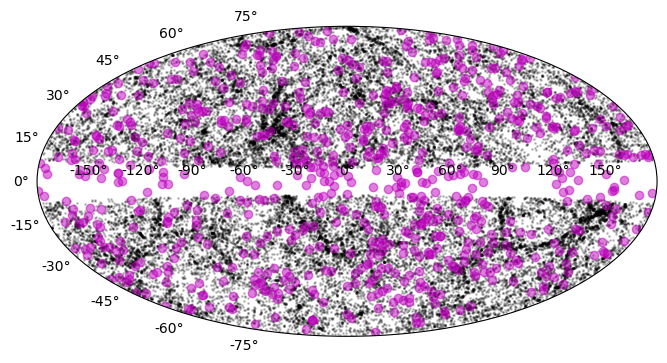

In [11]:
ra1 = coord.Angle(agn['ra']*u.degree)
ra1 = ra1.wrap_at(180*u.degree)
dec1 = coord.Angle(agn['dec']*u.degree)

ra2 = coord.Angle(gal['l']*u.degree)
ra2 = ra2.wrap_at(180*u.degree)
dec2 = coord.Angle(gal['b']*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
#y1 = coord.Angle(8*u.degree)
#y2 = coord.Angle(-8*u.degree)

ax.scatter(ra2.radian, dec2.radian,1,color='k',alpha=.2)
ax.scatter(ra1.radian, dec1.radian,color='m',alpha=.5)


## Make random catalogs

Using sensitivity maps for 70 month survey


Set MJD-OBS to 53355.002572 from DATE-OBS.
Set MJD-END to 55469.117384 from DATE-END'. [astropy.wcs.wcs]


number of randoms: 55790


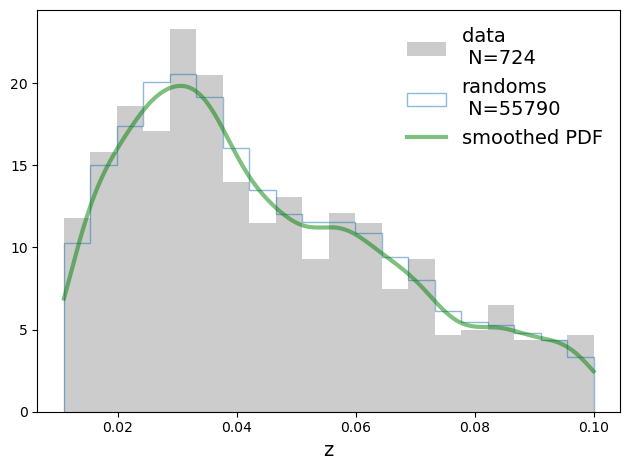

In [12]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)

#100: 100X randoms as AGN

In [13]:
arand.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'flux', 'cdist')

number of randoms: 887041


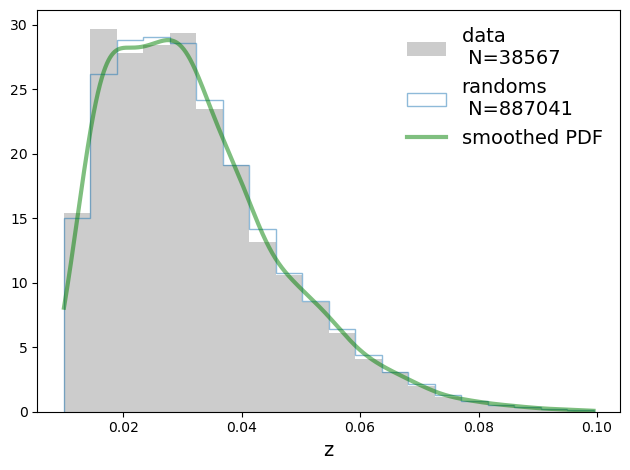

In [14]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

## specify clustering parameters
pi_max: maximum seperation in redshift space that we integrate to (max length we average over)  
nbins: number of projected spatial bins

In [15]:
pimax=40
pibins = np.logspace(0,np.log10(40),6, dtype=int)

# to compare better with pibins
binsmod = np.logspace(0,np.log10(40),6,dtype=int)
binsmod = binsmod.astype(dtype=float)
binsmod = np.insert(binsmod, 0, 0.1)

nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)
print(bins)

[ 0.1         0.18205642  0.3314454   0.60341763  1.09856054  2.
  3.64112841  6.62890803 12.06835267 21.97121087 40.        ]


## Autocorrelate AGN

Using the Landy-Szalay estimator for the correlation function:   

$\xi(r_{p},\pi) = \frac{DD - 2DR + RR}{RR}$   
DD: # data-data pairs   
DR: # data-random pairs    
RR: # random-random pairs   

$w_{p} = 2 \int^{\pi_{\rm{max}}}_{0} \xi(r_{p},\pi) d\pi$

$r_p$: spatial separation perpendicular to the line of sight   
$\pi$: spatial separation parallel to the line of sight   

In [16]:
rp,wp_aa,wp_aa_err,cov = w.auto_wp(agn, arand, bins, pimax, 5, estimator='L')
# the 5 refers to the square root of the number of jackknife samples used to estimate the errors


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.211 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.201 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.215 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.214 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.014 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.213 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.201 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.214 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.192 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.199 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.201 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.183 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.208 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.223 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.215 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.212 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.220 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.218 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.014 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


Plot

Text(0.5, 1.0, 'AGN ACF')

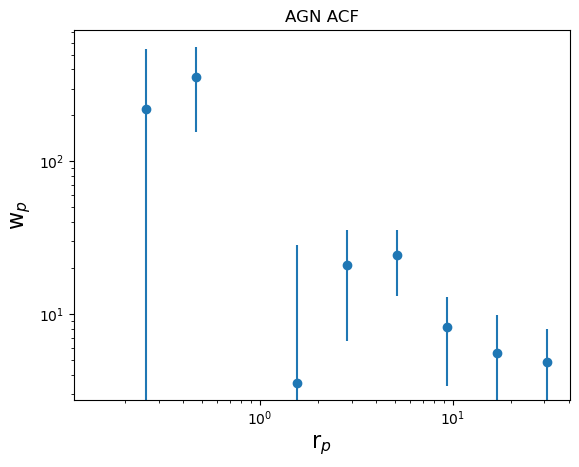

In [17]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_aa,yerr=wp_aa_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN ACF')

There's a signal, but the errors are pretty large

## Cross-correlate AGN with galaxies

$\xi(r_{p},\pi) = \frac{D_{1}D_{2} - D_{1}R_{2} - D_{2}R_{1} + R_{1}R_{2}}{R_{1}R_{2}}$   

1: AGN   
2: Galaxies

In [18]:
t1=time.time()
rp,wp_ag,wp_ag_err,Mag= w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.090 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.120 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.......100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........6

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

In [19]:
print('took ',str(t/60),' minutes')

took  2.9770103732744855  minutes


Text(0.5, 1.0, 'AGN XCF')

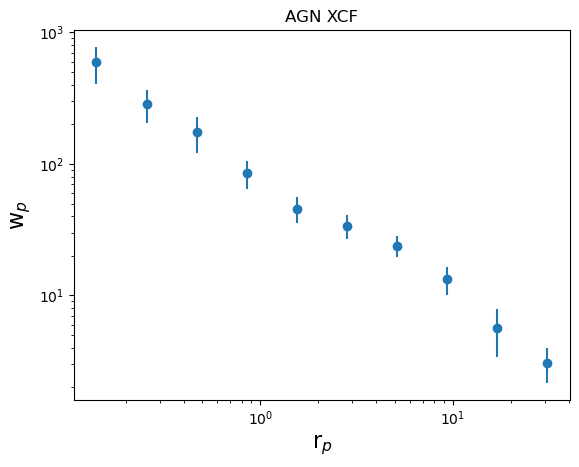

In [20]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')

better!

Try another estimator (Davis & Peebles):
$\xi(r_{p},\pi) = \frac{D_{1}D_{2}}{D_{1}R_{2}} - 1$   

In [21]:
#%%timeit
t1=time.time()
rp,wp_agp,wp_agp_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.106 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs


In [22]:
print('took ',str(t),' seconds')

took  11.108796119689941  seconds


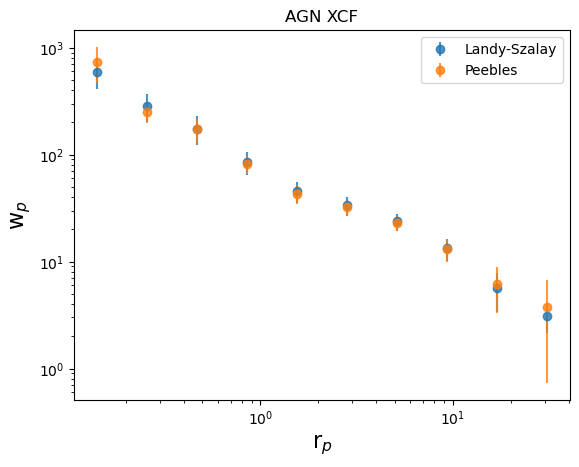

In [23]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o',label='Landy-Szalay',alpha=0.8)
plt.errorbar(rp,wp_agp,yerr=wp_agp_err,fmt='o',label='Peebles',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()

In [25]:
# Collapsing 2d correlation function along rp - Auto_wp Landay-Szalay
%autoreload 2
pi,wppi_aa = wz.auto_wppi(agn, arand, bins, pibins, pimax, 5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.211 secs


[ 91.44943072 318.37837818  90.39041671  33.66683614  42.81974693
  40.88625145]


Text(0.5, 1.0, 'AGN ACF')

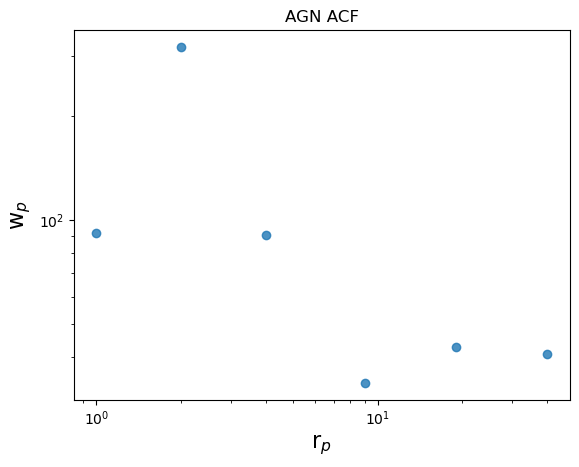

In [26]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pibins,wppi_aa, alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN ACF')

In [27]:
# Collapsing 2d correlation function alon rp - Landay Estimator
%autoreload 2
pi, wppi_ls = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.109 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%........

In [29]:
# Collapsing 2d correlation function along rp- Peebles Estimator
%autoreload 2
pi,wppi_p = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pibins=pibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


Text(0.5, 1.0, 'Scatter Plot of Log Binned Pi Peebles')

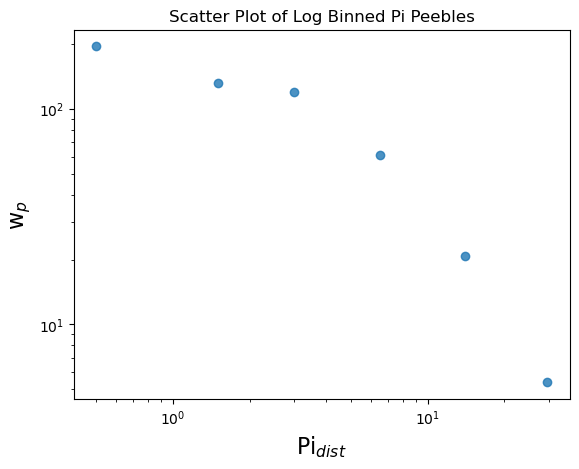

In [33]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_p,alpha=0.8)
plt.xlabel('Pi$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Scatter Plot of Log Binned Pi Peebles')

Text(0.5, 1.0, 'Scatter Plot of Log Binned Landay-Szalay')

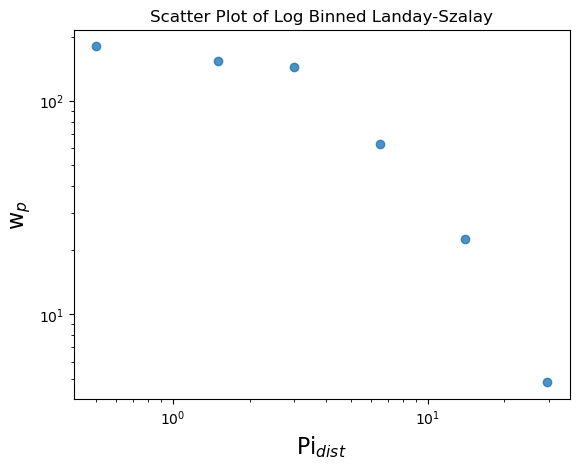

In [32]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_ls,alpha=0.8)
plt.xlabel('Pi$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Scatter Plot of Log Binned Landay-Szalay')

Text(0.5, 1.0, 'Scatter Plot of Log Binned Pi Peebles Vs. Landay-Szalay')

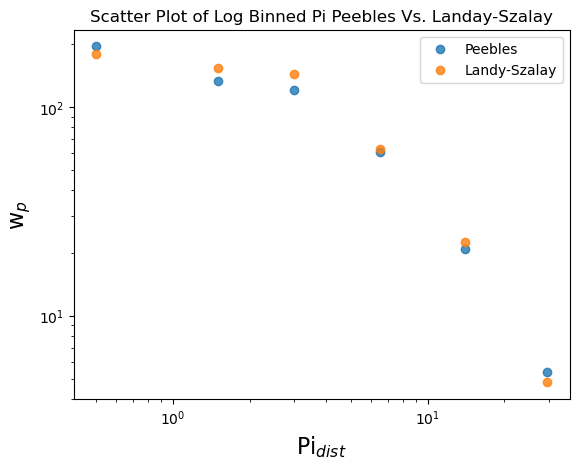

In [34]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_p,label='Peebles',alpha=0.8)
plt.scatter(pi,wppi_ls,label="Landy-Szalay",alpha=0.8)
plt.legend()
plt.xlabel('Pi$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Scatter Plot of Log Binned Pi Peebles Vs. Landay-Szalay')

In [35]:
rp_mod,wp_agp_mod,wp_agp_err_mod,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.072 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.118 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%..100% done. Time taken =  0.107 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.110 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.085 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


Text(0.5, 1.0, 'Clustering of pi vs rp')

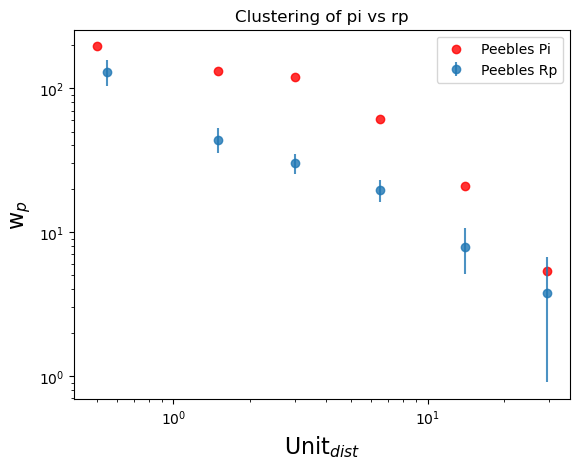

In [36]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_p,c='red',label='Peebles Pi',alpha=0.8)
plt.errorbar(rp_mod,wp_agp_mod,yerr=wp_agp_err_mod,fmt='o',label='Peebles Rp',alpha=0.8)
plt.legend()
plt.xlabel('Unit$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Clustering of pi vs rp')

In [37]:
rp_mod,wp_ag_mod,wp_ag_mod_err,Mag= w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.106 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%........

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.007 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%........

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%......100% done. Time taken =  0.108 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,9.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%........

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,9.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%........

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%........

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%........

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%........

Text(0.5, 1.0, 'Clustering of pi vs rp')

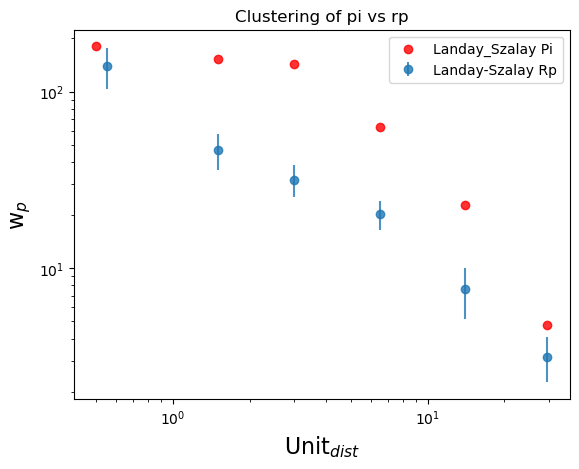

In [38]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_ls,c='red',label='Landay_Szalay Pi',alpha=0.8)
plt.errorbar(rp_mod,wp_ag_mod,yerr=wp_ag_mod_err,fmt='o',label='Landay-Szalay Rp',alpha=0.8)
plt.legend()
plt.xlabel('Unit$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Clustering of pi vs rp')

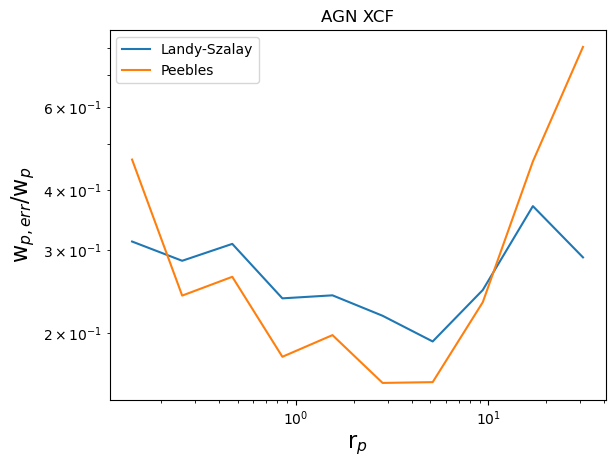

In [72]:
plt.yscale("log")
plt.xscale("log")
plt.plot(rp,wp_ag_err/wp_ag,label='Landy-Szalay')
plt.plot(rp,wp_agp_err/wp_agp,label='Peebles')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p,err}$/w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()